## Summary Stats for Processed AFT Dataset

**Author:** Jim Maddock

**Last Updated:** 5-19-20

**Description:** An initial explortion of the `vital 1000` dataset created by EdCast.  The dataset contains explicit links defined by the vital 1k taxonomy, and implicit links between leaf nodes.  The goal of this notebook is to understand the overlap (and usefulness) of these explicit links.

Definitions:
* **parent/child nodes:** an explicit topic/subtopic relationship
* **sibling nodes:** nodes that share the same parent
* **neighbor nodes:** leaf nodes that have an implicit relationship

Rules:
* nodes can be neighbors and siblings
* nodes cannot be neighbors and a child/parent

### Notebook setup

In [97]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [2]:
FILEPATH = '/home/jmads/data/knowledge_graph/wiki_vitals_graph.json'

with open(FILEPATH) as json_file:
    graph = json.load(json_file)

In [16]:
def makeEdgeDf(graph):

    edge_df = pd.DataFrame()
    visited_edges = []
    for e in graph['tree_data']['edges']:
        if (e[1],e[0]) not in visited_edges:
            visited_edges.append((e[0], e[1]))
            try:
                df_dict = {
                    'n1':e[0],
                    'n2':e[1],
                    'type':e[2]['type']
                }
                if 'depth' in e[2]:
                    df_dict['depth'] = e[2]['depth']
                else:
                    df_dict['depth'] = None
                if 'w' in e[2]:
                    df_dict['w'] = e[2]['w']
                else:
                    df_dict['w'] = None
            except:
                print(e)
                raise
            edge_df = edge_df.append(pd.DataFrame([df_dict]))
        
    return edge_df

edge_df = makeEdgeDf(graph)

In [11]:
def makeNodeDf(graph):

    node_df = pd.DataFrame()
    for n in graph['tree_data']['nodes']:
        try:
            df_dict = {
                'id':n[1]['id'],
                'name':n[1]['name'],
                'type':n[1]['kind']
            }
        except:
            print(e)
            raise
        node_df = node_df.append(pd.DataFrame([df_dict]))
        
    return node_df

node_df = makeNodeDf(graph)

In [90]:
def makeTestDf(edge_df,node_df):
    test_df = pd.DataFrame()
    leaf_edge_df = edge_df.loc[edge_df['type'] == 'neighbor_of']
    parent_key_list = []
    
    for i,e in leaf_edge_df.iterrows():
        p1 = getParent(edge_df,e['n1'])
        p2 = getParent(edge_df,e['n2'])
        if (p2,p1) in parent_key_list:
            parent_key = (p2,p1)
            reverse = True
        else:
            parent_key = (p1,p2)
            parent_key_list.append((p1,p2))
            reverse= False
            
        parent_names = (
            node_df.loc[node_df['id'] == parent_key[0]]['name'].tolist()[0],
            node_df.loc[node_df['id'] == parent_key[1]]['name'].tolist()[0]
        )
        
        if reverse:
            node_names = (
                node_df.loc[node_df['id'] == e['n2']]['name'].tolist()[0],
                node_df.loc[node_df['id'] == e['n1']]['name'].tolist()[0]
            )
        else:
            node_names = (
                node_df.loc[node_df['id'] == e['n1']]['name'].tolist()[0],
                node_df.loc[node_df['id'] == e['n2']]['name'].tolist()[0]
            )
            
        df_dict = {
            'n1':e['n1'],
            'n2':e['n2'],
            'p1':p1,
            'p2':p2,
            'parent_key':parent_key,
            'parent_names':parent_names,
            'node_names':node_names,
            'sibling':p1 == p2
        }
        test_df = test_df.append([df_dict])
    return test_df
        
def getParent(edge_df, node):
    edge = edge_df.loc[(edge_df['n2'] == node) & (edge_df['type'] == 'subtopic_of')]
    if len(edge) > 1:
        raise
    else:
        parent = edge['n1'].tolist()[0]
        return parent

test_df = makeTestDf(edge_df,node_df)

### Dataset Summary
**Takeaways:**
* Many more neighbors that are not siblings.  This could mean that the taxonomy is not accurately capturing all relationships present between articles (i.e. many articles are related to each other but belong to different categories)


* Distribution of double parents for neighbors follows a power law.  

    * A few category pairs (e.g. "politics and government" and "social issues") have many articles that are neighbors but not siblings.  This probably means that there is a lot of overlap between these categories which is not explicitly captured by the taxonomy.
    * 50% of category pairs have 1 only 1 pair of articles that are neighbors that are not siblings.  This could mean that most categories are only loosely connected to one another.

Number of neighboring articles that:
* Are siblings, e.g. have the same parent (true)
* Are not siblings, e.g. don't have the same parent (false)

In [77]:
test_df.groupby('sibling').size()

sibling
False    2459
True     1116
dtype: int64

Number of unique parent node pairs (topics) for articles that are neighbors but not siblings

In [44]:
test_df.loc[test_df['sibling'] == False]['parent_key'].nunique()

932

Counts of topic pairs for articles that are neighbors but not siblings.  For instance there are 25 article pairs where article 1 is categorized under politics and government and article 2 is categorized under social issues, but the articles are defined as neighbors

In [62]:
test_df.loc[test_df['sibling'] == False].groupby(['parent_key','parent_names']).size().to_frame('count').sort_values('count',ascending=False)

,,count
parent_key,parent_names,
"(5100852983775534048, 5100852986084041525)","(basics, other)",27
"(5100852915991611456, 5100852918718102047)","(politics_and_government, social_issues)",25
"(5100853078359029286, 5100853097569871895)","(modern_history, history_by_region)",19
"(5100852983775534048, 5100852988106840452)","(basics, arithmetic)",19
"(5100853005429375777, 5100853097569871895)","(countries, history_by_region)",18
"(5100853005429375777, 5100853078359029286)","(countries, modern_history)",17
"(5100852872145229213, 5100853075223214322)","(politicians_and_leaders, post-classical_history)",16
"(5100852872145229213, 5100853093169015356)","(politicians_and_leaders, ancient_history)",16
"(5100852873028411338, 5100852970116908916)","(philosophers_and_social_scientists, philosophy)",16


Histogram of the above table.  Most categories have 1 or 2 pairs of articles that are neighbors but not siblings.  Seems to follow a power law distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58db1eef60>]],
      dtype=object)

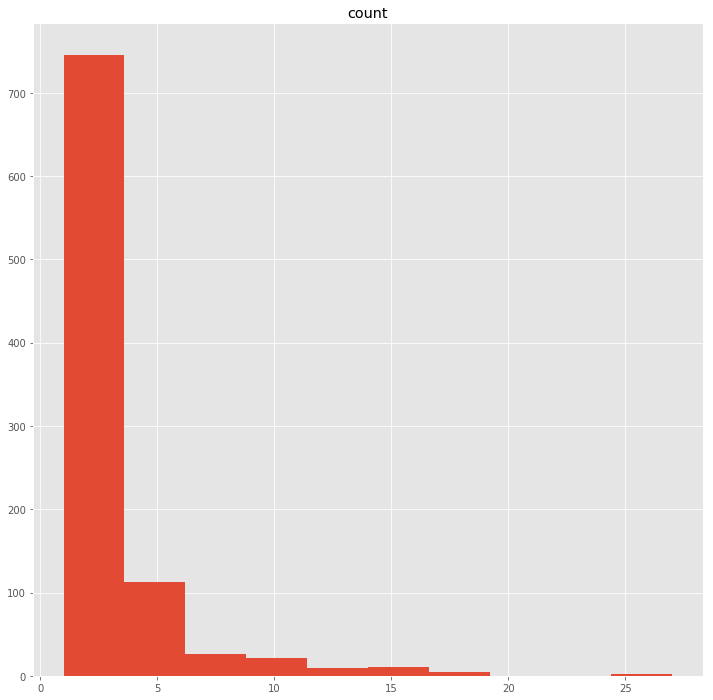

In [54]:
test_df.loc[test_df['sibling'] == False].groupby('parent_key').size().to_frame('count').hist(figsize=(12,12))

In [98]:
test_df.loc[test_df['sibling'] == False].groupby('parent_key').size().to_frame('count').quantile(np.arange(0,1,.1))

,count
0.0,1.0
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,2.0
0.6,2.0
0.7,2.0
0.8,3.0
0.9,6.0


### Samples

**Setup:** The following tables contain pairs of articles that are neighbors but not siblings for various topics

1. a random sample of article pairs that are neighbors but not siblings (100 articles)
1. neighbor article pairs that have the parent categories "basics" and "other" (27 articles)
1. neighbor article pairs that have the parent categories "politics_and_government" and "social_issues" (25 articles)
1. neighbor article pairs that have the parent categories "modern_history" and "history_by_region" (19 articles)

**Takeaways:**
* Most neighbors seem to be reasonably related, although most neighbors wouldn't necessarily belong to the same category even though they are related.
    * For instance, "united_nations" and "human_rights" are related articles, but it makes sense for united_nations to remain under "politics_and_government" and human rights to remain under "social_issues".  It's not necessarily clear what we do with this relationship.


* Category pairs that have fewer neighbors seem to be less likely to actually make sense.
    * For instance, most of the pairs under "politics_and_government" and "social_issues" seem related, but it's not clear why "ship" and "brazil" are related, or "thought" and "amazon river"
    * This also could be an artifact of the power law distribution.  There are a lot more topic pairs with 1 pair of neighbor articles.  The actual number of "wrong" relationships is higher but the rate is the same.
    

* We have a lot of variability here and this is hard to spot check
    * Relatedness is a spectrum, not binary.  There are different reasons why articles would be related.  It's not clear what to mark as a valid relationship and what is not valid.
    * If this dataset were to get much bigger there would be too many articles to reasonably spot check


* **Even when relationships are valid, it's not clear how to leverage this into better categorization of WP or understanding what is missing from WP.**  How could we use this to:
    * create better categories than we already have?
    * understand when articles are mis-categorized?


In [100]:
SEED = 128
SAMPLE_SIZE = 100

pd.set_option("max_rows", 100)
cols = ['count','parent_names','node_names']
size = test_df.loc[test_df['sibling'] == False].groupby('parent_key').size().to_frame('count').reset_index()
temp = test_df.loc[test_df['sibling'] == False].merge(size, on='parent_key')
temp.loc[temp['count'] == 1].sample(SAMPLE_SIZE, random_state=SEED)[cols]

,count,parent_names,node_names
1662,1,"(general, history_by_region)","(jewellery, history_of_asia)"
1143,1,"(illness_and_injury, food_and_health)","(cancer, garden)"
649,1,"(artists, inventors_and_scientists)","(pablo_picasso, benjamin_franklin)"
2324,1,"(structures, illness_and_injury)","(bridge, mental_disorder)"
2322,1,"(structures, politics_and_government)","(infrastructure, political_science)"
1689,1,"(recreation_and_entertainment, politicians_and...","(martial_arts, george_washington)"
653,1,"(artists, cities)","(frida_kahlo, mexico_city)"
1494,1,"(psychology, hydrologic_features)","(thought, amazon_river)"
1555,1,"(general, navigation_and_timekeeping)","(folklore, radar)"
1975,1,"(terrestrial_features, performing_arts)","(andes, theatre)"


In [92]:
cols = ['parent_names','node_names']
test_df.loc[(test_df['sibling'] == False) & (test_df['parent_names'] == ('basics','other'))].sort_values(cols)[cols]

,parent_names,node_names
0,"(basics, other)","(0, infinity)"
0,"(basics, other)","(e_(mathematical_constant), function_(mathemat..."
0,"(basics, other)","(e_(mathematical_constant), limit_(mathematics))"
0,"(basics, other)","(e_(mathematical_constant), variable_(mathemat..."
0,"(basics, other)","(integer, algebra)"
0,"(basics, other)","(integer, set_(mathematics))"
0,"(basics, other)","(mathematics, algebra)"
0,"(basics, other)","(mathematics, combinatorics)"
0,"(basics, other)","(mathematics, mathematical_analysis)"
0,"(basics, other)","(mathematics, mathematical_proof)"


In [93]:
cols = ['parent_names','node_names']
test_df.loc[(test_df['sibling'] == False) & (test_df['parent_names'] == ('politics_and_government', 'social_issues'))].sort_values(cols)[cols]

,parent_names,node_names
0,"(politics_and_government, social_issues)","(anarchism, terrorism)"
0,"(politics_and_government, social_issues)","(colonialism, human_migration)"
0,"(politics_and_government, social_issues)","(colonialism, racism)"
0,"(politics_and_government, social_issues)","(communism, constitution)"
0,"(politics_and_government, social_issues)","(government, genocide)"
0,"(politics_and_government, social_issues)","(ideology, racism)"
0,"(politics_and_government, social_issues)","(imperialism, globalization)"
0,"(politics_and_government, social_issues)","(international_monetary_fund, globalization)"
0,"(politics_and_government, social_issues)","(international_monetary_fund, law)"
0,"(politics_and_government, social_issues)","(liberalism, liberty)"


In [94]:
cols = ['parent_names','node_names']
test_df.loc[(test_df['sibling'] == False) & (test_df['parent_names'] == ('modern_history', 'history_by_region'))].sort_values(cols)[cols]

,parent_names,node_names
0,"(modern_history, history_by_region)","(age_of_discovery, history_of_north_america)"
0,"(modern_history, history_by_region)","(age_of_discovery, history_of_oceania)"
0,"(modern_history, history_by_region)","(age_of_enlightenment, history_of_europe)"
0,"(modern_history, history_by_region)","(british_empire, history_of_india)"
0,"(modern_history, history_by_region)","(cold_war, history_of_europe)"
0,"(modern_history, history_by_region)","(european_colonization_of_the_americas, histor..."
0,"(modern_history, history_by_region)","(european_colonization_of_the_americas, histor..."
0,"(modern_history, history_by_region)","(european_colonization_of_the_americas, histor..."
0,"(modern_history, history_by_region)","(french_revolution, history_of_europe)"
0,"(modern_history, history_by_region)","(great_depression, history_of_asia)"
